<a href="https://colab.research.google.com/github/Shiv-Expert2503/SigLIP2-CompleteLoss/blob/main/Locca_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# I start by installing all the required libraries.
# - transformers: For loading the tokenizer.
# - datasets: For easily loading the COCO/Conceptual Captions dataset.
# - timm: A great library for computer vision models, used here for our ViT.
# - matplotlib: For plotting our loss curve later.
# The "-q" flag makes the installation quieter.

!pip install transformers datasets torch timm matplotlib -q

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets.utils.logging import disable_progress_bar
import math
import timm
import random
from tqdm.auto import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO


print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
print("Loading a slice of the Conceptual Captions dataset...")
# Note: We can also use "coco_captions" if you prefer(@superhotdog).
dataset = load_dataset("conceptual_captions", split="train[:5000]")

# Let's inspect the loaded dataset to see its structure.
print("\nDataset loaded successfully!")
print(dataset)
print("\nExample entry:")
print(dataset[0])

Loading a slice of the Conceptual Captions dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

unlabeled/train-00000-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

unlabeled/train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

unlabeled/validation-00000-of-00001.parq(…):   0%|          | 0.00/1.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]


Dataset loaded successfully!
Dataset({
    features: ['image_url', 'caption'],
    num_rows: 5000
})

Example entry:
{'image_url': 'http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/AAAAAAAAM6o/_11MuAAKalQ/IMG_3422.JPG?imgmax=800', 'caption': 'a very typical bus station'}


In [5]:
# The tokenizer converts the text captions into numerical IDs that the model
# can understand. I'll use the tokenizer from GPT2, which is a standard choice.
#
# A crucial step is to ensure a padding token is set. The padding token is used
# to make all sequences in a batch have the same length. If a tokenizer doesn't
# have a pre-defined pad token, a common practice is to use the end-of-sentence
# (eos) token for this purpose.

print("Loading tokenizer")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Check if a pad token exists. If not, set it to the eos_token.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Tokenizer did not have a pad_token, setting it to eos_token.")

print("\nTokenizer loaded and configured:")
print(f"  - Pad token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
print(f"  - Vocab size: {tokenizer.vocab_size}")

if tokenizer.mask_token is None:
    tokenizer.add_special_tokens({'mask_token': '[MASK]'})
    print(f"Added mask token: '{tokenizer.mask_token}' (ID: {tokenizer.mask_token_id})")

# IMPORTANT: After adding special tokens, vocab size changes!
print(f"  - Updated vocab size: {len(tokenizer)}")

Loading tokenizer


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer did not have a pad_token, setting it to eos_token.

Tokenizer loaded and configured:
  - Pad token: '<|endoftext|>' (ID: 50256)
  - Vocab size: 50257
Added mask token: '[MASK]' (ID: 50257)
  - Updated vocab size: 50258


In [6]:
# This is the part of the model that "sees" the image.
# I've use a pre-trained Vision Transformer (ViT) from the `timm` library.
#
# Key Steps:
# 1. `pretrained=True`: I load weights that are already trained on a large
#    dataset (ImageNet-21k). This gives me a powerful vision backbone for free.
# 2. `eval()`: I set the model to evaluation mode because I am not training it.
# 3. Freeze Weights: I iterate through all its parameters and set
#    `param.requires_grad = False`. This "freezes" the vision encoder, meaning
#    its weights won't be updated during training. This isolates the training
#    to only my new AR Decoder, making the smoke test faster and more stable.

print("Loading pre-trained Vision Transformer (ViT)...")
# Using a base-sized ViT with 16x16 patches, trained on ImageNet-21k
vision_encoder = timm.create_model(
    'vit_base_patch16_224.augreg_in21k',
    pretrained=True
).to(device)

# Set to evaluation mode and freeze all parameters
vision_encoder.eval()
for param in vision_encoder.parameters():
    param.requires_grad = False

print("\nVision encoder loaded and frozen successfully!")
print(f"Model: {vision_encoder.default_cfg['architecture']}")


vision_config = vision_encoder.default_cfg
encoder_hidden_dim = vision_encoder.num_features  # Usually 768 for base ViT

print(f"  - Hidden dimension: {encoder_hidden_dim}")
print(f"  - Image size: {vision_config['input_size']}")

# Store for Phase 1
ENCODER_HIDDEN_DIM = encoder_hidden_dim

# This print statement shows the structure of the model.
# print(vision_encoder)

Loading pre-trained Vision Transformer (ViT)...


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]


Vision encoder loaded and frozen successfully!
Model: vit_base_patch16_224
  - Hidden dimension: 768
  - Image size: (3, 224, 224)


In [7]:
encoder_config = {
    'hidden_size': vision_encoder.num_features,  # 768 for base
    'num_hidden_layers': 12,  # ViT-Base has 12 encoder layers
    'num_attention_heads': 12,  # Standard for 768-dim
    'intermediate_size': 3072  # 4x hidden_size for FFN
}

In [8]:
print("\n\n--- Phase 0 Setup Complete! ---")
print("I now have:")
print(f"1. A working environment on device: {device}")
print(f"2. A dataset with {len(dataset)} examples.")
print(f"3. A configured tokenizer with a vocab size of {tokenizer.vocab_size}.")
print("4. A powerful, frozen vision encoder ready to create image embeddings.")
print("\n Proceeding to Phase 1: Building the AR Decoder.")

print(f"\nEncoder config for decoder:")
print(f"  - Hidden size: {encoder_config['hidden_size']}")
print(f"  - Encoder layers: {encoder_config['num_hidden_layers']}")
print(f"  - Decoder layers: {encoder_config['num_hidden_layers'] // 2}")
print(f"  - Attention heads: {encoder_config['num_attention_heads']}")
print(f"  - FFN size: {encoder_config['intermediate_size']}")



--- Phase 0 Setup Complete! ---
I now have:
1. A working environment on device: cuda
2. A dataset with 5000 examples.
3. A configured tokenizer with a vocab size of 50257.
4. A powerful, frozen vision encoder ready to create image embeddings.

 Proceeding to Phase 1: Building the AR Decoder.

Encoder config for decoder:
  - Hidden size: 768
  - Encoder layers: 12
  - Decoder layers: 6
  - Attention heads: 12
  - FFN size: 3072


# Phase 1

In [9]:
class SigLIP2ARDecoder(nn.Module):
    """
    This is the Autoregressive (AR) Decoder for the SigLIP2 model.

    I designed this module to generate captions token-by-token based on
    visual features from a vision encoder. It's a standard Transformer
    decoder with specific modifications mentioned in the research papers,
    such as using Pre-LayerNorm and no bias in key layers.

    Attributes:
        embedding (nn.Embedding): Converts token IDs to dense vectors.
        pos_encoder (nn.Parameter): A learnable positional encoding added to token embeddings.
        decoder (nn.TransformerDecoder): The stack of Transformer decoder layers.
        lm_head (nn.Linear): The final layer that projects decoder outputs to vocabulary logits.
    """
    def __init__(self, config, vocab_size):
        """
        Initializes the AR Decoder module.

        Args:
            config (dict): A dictionary containing the model's architectural parameters,
                           such as hidden_size, num_layers, and num_heads. I expect
                           this to be derived from the vision encoder's config.
            vocab_size (int): The total size of the vocabulary, including any
                              special tokens I've added.
        """
        super().__init__()
        self.config = config

        # 1. Token and Positional Embeddings
        # The embedding layer maps input token IDs to vectors of size `hidden_size`.
        self.embedding = nn.Embedding(vocab_size, config['hidden_size'])

        # I am using learnable absolute positional encodings, a common choice.
        # I've set a max sequence length of 77, typical for models like CLIP.
        self.max_seq_length = 77
        # self.pos_encoder = nn.Parameter(torch.zeros(1, self.max_seq_length, config['hidden_size'])) #---- initalize all 0
        # Better initialization for positional encodings
        self.pos_encoder = nn.Parameter(torch.randn(1, self.max_seq_length, config['hidden_size']) * 0.02) #-----Learnable initialization for positional encodings(used in the paper)

        # Sinusoidal positional encoding (used in original Transformer)----------------- static init.
        # pe = torch.zeros(self.max_seq_length, config['hidden_size'])
        # position = torch.arange(0, self.max_seq_length).unsqueeze(1).float()
        # div_term = torch.exp(torch.arange(0, config['hidden_size'], 2).float() *
        #                     -(math.log(10000.0) / config['hidden_size']))
        # pe[:, 0::2] = torch.sin(position * div_term)
        # pe[:, 1::2] = torch.cos(position * div_term)
        # self.pos_encoder = nn.Parameter(pe.unsqueeze(0))


        # 2. Decoder Layer Setup
        # I first define a single decoder layer with all the required specifications.
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=config['hidden_size'],
            nhead=config['num_attention_heads'],
            dim_feedforward=config['intermediate_size'],
            activation='gelu',   # As specified
            bias=False,          # As specified
            norm_first=True,     # This enables Pre-LayerNorm (Pre-LN)
            batch_first=True     # This is crucial for handling tensors with shape [batch, seq, dim]
        )

        # 3. Decoder Stack
        # I now stack these layers to create the full Transformer Decoder.
        # The depth is half that of the vision encoder.
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=config['num_hidden_layers'] // 2
        )

        # 4. Language Model Head
        # This final linear layer projects the decoder's output into logits
        # over the entire vocabulary.
        self.lm_head = nn.Linear(config['hidden_size'], vocab_size, bias=False)

    def forward(self, input_ids, encoder_hidden_states, tgt_mask="auto"):
      """
      Performs forward pass with flexible masking.

      Args:
          tgt_mask: "auto" = create causal mask (AR)
                    None = no mask (parallel prediction)
                    Tensor = custom mask
      """
      seq_len = input_ids.size(1)
      device = input_ids.device

      # Token + positional embeddings
      token_embeds = self.embedding(input_ids)
      positional_embeds = self.pos_encoder[:, :seq_len, :]
      input_embeds = token_embeds + positional_embeds

      # Create or use mask
      if tgt_mask == "auto":
          tgt_mask = nn.Transformer.generate_square_subsequent_mask(
              seq_len, device=device, dtype=torch.float32
          )
      # If tgt_mask is None, no mask is applied (full attention)

      decoder_output = self.decoder(
          tgt=input_embeds,
          memory=encoder_hidden_states,
          tgt_mask=tgt_mask
      )

      logits = self.lm_head(decoder_output)
      return logits


print("SigLIP2ARDecoder class defined successfully.")

SigLIP2ARDecoder class defined successfully.


In [10]:
def get_logits_with_dual_mode(decoder, encoder_hidden_states, labels, tokenizer, parallel_pred_ratio=0.75):
    """
    Dual-mode training: AR (causal) vs Parallel (no mask).
    """
    if random.random() < parallel_pred_ratio:
        # --- Parallel Prediction Path ---
        masked_input_ids = torch.full_like(labels, fill_value=tokenizer.mask_token_id)

        # Preserve padding
        masked_input_ids[labels == tokenizer.pad_token_id] = tokenizer.pad_token_id

        # NO MASK = full bidirectional attention
        logits = decoder(
            input_ids=masked_input_ids,
            encoder_hidden_states=encoder_hidden_states,
            tgt_mask=None  # Explicitly no mask
        )
    else:
        # --- Autoregressive Path ---
        # Shift input by prepending BOS
        batch_size = labels.size(0)
        device = labels.device
        bos_token = torch.full((batch_size, 1), tokenizer.bos_token_id or tokenizer.eos_token_id,
                              dtype=labels.dtype, device=device)
        decoder_input_ids = torch.cat([bos_token, labels[:, :-1]], dim=1)

        # AUTO = create causal mask
        logits = decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=encoder_hidden_states,
            tgt_mask="auto"  # Creates causal mask
        )

    return logits


In [11]:
# --- Setup for the test ---
# I'll use the config and tokenizer from our Phase 0 setup.
# I need to make sure the vocab size is correct after adding the [MASK] token.
vocab_size = len(tokenizer)

# --- 1. Instantiate the Decoder ---
# I'm creating an instance of my new decoder and moving it to the GPU.
print("Instantiating the AR Decoder for a unit test...")
decoder = SigLIP2ARDecoder(config=encoder_config, vocab_size=vocab_size).to(device)
print("Decoder instantiated successfully.")

# --- 2. Create Dummy Input Tensors ---
# I need to create fake data that mimics the real inputs the decoder will receive.
BATCH_SIZE = 4
SEQ_LENGTH = 20
NUM_PATCHES = 197 # For a 224x224 image with 16x16 patches, it's 14x14=196 patches + 1 [CLS] token.

# Dummy output from the vision encoder (e.g., ViT).
dummy_encoder_output = torch.randn(
    BATCH_SIZE, NUM_PATCHES, encoder_config['hidden_size']
).to(device)

# Dummy input token IDs (e.g., from a tokenized caption).
dummy_input_ids = torch.randint(
    0, vocab_size, (BATCH_SIZE, SEQ_LENGTH)
).to(device)

print(f"\nCreated dummy inputs:")
print(f"  - Encoder output shape: {dummy_encoder_output.shape}")
print(f"  - Input IDs shape: {dummy_input_ids.shape}")

# --- 3. Run the Forward Pass and Check Output ---
# This is the moment of truth. I'll pass the dummy data through the decoder.
print("\nRunning forward pass...")
try:
    with torch.no_grad(): # I don't need to compute gradients for this test
        output_logits = decoder(dummy_input_ids, dummy_encoder_output)
    print("Forward pass completed without errors.")

    # Check the output shape
    expected_shape = (BATCH_SIZE, SEQ_LENGTH, vocab_size)
    print(f"  - Output logits shape: {output_logits.shape}")
    print(f"  - Expected shape:      {expected_shape}")

    assert output_logits.shape == expected_shape
    print("\n Success! The output shape is correct.")

except Exception as e:
    print(f"\n Error during forward pass: {e}")

# --- Phase 1 Complete ---
print("\n\n--- Phase 1 Complete! ---")
print("The standalone AR Decoder module is built and verified.")

Instantiating the AR Decoder for a unit test...
Decoder instantiated successfully.

Created dummy inputs:
  - Encoder output shape: torch.Size([4, 197, 768])
  - Input IDs shape: torch.Size([4, 20])

Running forward pass...
Forward pass completed without errors.
  - Output logits shape: torch.Size([4, 20, 50258])
  - Expected shape:      (4, 20, 50258)

 Success! The output shape is correct.


--- Phase 1 Complete! ---
The standalone AR Decoder module is built and verified.


# Phase 2

Implementing the core logic from the CapPa paper

In [12]:
# --- Test 1: Force AR Path (else block) ---
print("--- Testing AR Path (should use causal mask) ---")
# To force else block: ratio must be 0 or negative
ar_logits = get_logits_with_dual_mode(
    decoder, dummy_encoder_output, dummy_input_ids, tokenizer,
    parallel_pred_ratio=0.0  # random() < 0.0 is always False → else block
)
print(f"  - AR output shape: {ar_logits.shape}")
assert ar_logits.shape == expected_shape
print("AR Path test successful!")

# --- Test 2: Force Parallel Path (if block) ---
print("\n--- Testing Parallel Prediction Path (should use NO mask) ---")
# To force if block: ratio must be 1.0 or greater
pa_logits = get_logits_with_dual_mode(
    decoder, dummy_encoder_output, dummy_input_ids, tokenizer,
    parallel_pred_ratio=1.0  # random() < 1.0 is always True → if block
)
print(f"  - Parallel output shape: {pa_logits.shape}")
assert pa_logits.shape == expected_shape
print("Parallel Path test successful!")

--- Testing AR Path (should use causal mask) ---
  - AR output shape: torch.Size([4, 20, 50258])
AR Path test successful!

--- Testing Parallel Prediction Path (should use NO mask) ---
  - Parallel output shape: torch.Size([4, 20, 50258])
Parallel Path test successful!


# Phase 3-> Testing
(Working)

In [17]:
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# def preprocess_data_robust(example):
#     try:
#         # Download and process the image
#         response = requests.get(example["image_url"], timeout=5)
#         response.raise_for_status()
#         image = Image.open(BytesIO(response.content)).convert("RGB")
#         pixel_values = image_transforms(image)

#         # Tokenize the caption
#         labels = tokenizer(
#             example["caption"],
#             padding="max_length",
#             truncation=True,
#             max_length=77,
#             return_tensors="pt"
#         )["input_ids"].squeeze() # Remove batch dim

#         return {"pixel_values": pixel_values, "labels": labels}
#     except Exception:
#         # If anything fails, return None so I can filter it out later.
#         return None

def preprocess_data_robust(example):
    """
    Process single example with success marker.
    MUST return a valid dict for multiprocessing to work!
    """
    try:
        # Download and process the image
        response = requests.get(example["image_url"], timeout=5)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")
        pixel_values = image_transforms(image)

        # Tokenize the caption
        labels = tokenizer(
            example["caption"],
            padding="max_length",
            truncation=True,
            max_length=77,
            return_tensors="pt"
        )["input_ids"].squeeze()

        # Return SUCCESS with data
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "is_valid": True  # Success marker
        }

    except Exception as e:
        # Return FAILURE with placeholders
        # CRITICAL: Must return a dict, not None!
        return {
            "pixel_values": torch.zeros(3, 224, 224),  # Dummy tensor
            "labels": torch.zeros(77, dtype=torch.long),  # Dummy tensor
            "is_valid": False  # Failure marker
        }

print("Starting data preprocessing (this will download images)...")
print("This may take 3-5 minutes for 5000 images...")
initial_count = len(dataset)

# Apply mapping with multiprocessing
processed_dataset = dataset.map(
    preprocess_data_robust,
    num_proc=4,
    remove_columns=["image_url", "caption"]
)

# Filter out failed examples using the marker
processed_dataset = processed_dataset.filter(lambda x: x["is_valid"])

# Remove the marker column (no longer needed)
processed_dataset = processed_dataset.remove_columns(["is_valid"])

final_count = len(processed_dataset)
success_rate = (final_count / initial_count) * 100

print(f"\nData preprocessing complete!")
print(f"Successfully processed: {final_count} / {initial_count} images ({success_rate:.1f}%)")
print(f"Failed/skipped: {initial_count - final_count} images")
print(processed_dataset)

Starting data preprocessing (this will download images)...
This may take 3-5 minutes for 5000 images...


Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]


Data preprocessing complete!
Successfully processed: 3345 / 5000 images (66.9%)
Failed/skipped: 1655 images
Dataset({
    features: ['pixel_values', 'labels'],
    num_rows: 3345
})


In [22]:
# def collate_fn(batch):
#     pixel_values = torch.stack([item['pixel_values'] for item in batch])
#     labels = torch.stack([item['labels'] for item in batch])
#     return {"pixel_values": pixel_values, "labels": labels}

# BATCH_SIZE = 32
# train_dataloader = DataLoader(processed_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
# print(f"DataLoader created with batch size {BATCH_SIZE}.")

def collate_fn(batch):
    """
    Custom collate function.
    CRITICAL: HuggingFace datasets stores tensors as lists in Arrow format.
    We must convert them back to tensors here!
    """
    # Convert lists back to tensors and stack
    pixel_values = torch.stack([
        torch.tensor(item['pixel_values']) if not isinstance(item['pixel_values'], torch.Tensor)
        else item['pixel_values']
        for item in batch
    ])

    labels = torch.stack([
        torch.tensor(item['labels']) if not isinstance(item['labels'], torch.Tensor)
        else item['labels']
        for item in batch
    ])

    return {"pixel_values": pixel_values, "labels": labels}

BATCH_SIZE = 32
train_dataloader = DataLoader(
    processed_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

print(f"DataLoader created with batch size {BATCH_SIZE}.")
print(f"Total batches per epoch: {len(train_dataloader)}")

DataLoader created with batch size 32.
Total batches per epoch: 105


In [23]:
optimizer = optim.AdamW(decoder.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# FIXED: Define vocab_size in this scope
vocab_size = len(tokenizer)
print(f"Optimizer, Loss Function, and Vocab Size ({vocab_size}) are set up.")

Optimizer, Loss Function, and Vocab Size (50258) are set up.


In [24]:
NUM_EPOCHS = 3
loss_history = []
print("Starting the smoke test training loop...")
decoder.train()
is_first_batch = True # Flag for shape verification

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{NUM_EPOCHS} ---")
    progress_bar = tqdm(train_dataloader, desc="Training")

    for batch in progress_bar:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            encoder_hidden_states = vision_encoder.forward_features(pixel_values)

        # FIXED: Use the optimal 0.75 ratio
        # --- As per ablation studies in the "Image Captioners..." paper (Table 4)
        logits = get_logits_with_dual_mode(
            decoder, encoder_hidden_states, labels, tokenizer, parallel_pred_ratio=0.75
        )

        # CRITICAL CHECK: Verify shapes on the first-ever batch
        if is_first_batch:
            print("\n--- First Batch Shape Verification ---")
            print(f"  - Pixel values:   {pixel_values.shape}")
            print(f"  - Encoder output: {encoder_hidden_states.shape}")
            print(f"  - Labels:         {labels.shape}")
            print(f"  - Logits:         {logits.shape}")
            print("------------------------------------")
            is_first_batch = False

        loss = loss_fn(logits.view(-1, vocab_size), labels.view(-1))

        optimizer.zero_grad()
        loss.backward()

        # FIXED: Add Gradient Clipping
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

        optimizer.step()

        loss_history.append(loss.item())
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

print("\nSmoke test training complete!")

# FIXED: Add Checkpoint Saving
checkpoint_path = 'siglip2_ar_decoder_checkpoint.pt'
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_history,
}, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}!")

Starting the smoke test training loop...

--- Epoch 1/3 ---


Training:   0%|          | 0/105 [00:00<?, ?it/s]


--- First Batch Shape Verification ---
  - Pixel values:   torch.Size([32, 3, 224, 224])
  - Encoder output: torch.Size([32, 197, 768])
  - Labels:         torch.Size([32, 77])
  - Logits:         torch.Size([32, 77, 50258])
------------------------------------

--- Epoch 2/3 ---


Training:   0%|          | 0/105 [00:00<?, ?it/s]


--- Epoch 3/3 ---


Training:   0%|          | 0/105 [00:00<?, ?it/s]


Smoke test training complete!
Model checkpoint saved to siglip2_ar_decoder_checkpoint.pt!


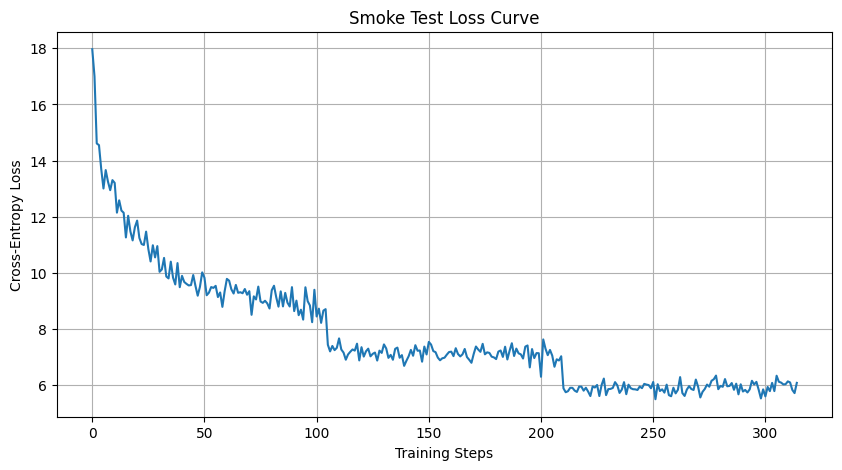

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Smoke Test Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()

# Issues_Tracker

1. Dataset Contains URLs, Not Images
2. Missing MASK Token in phase0 (fixed)
3. device Variable Not Defined in Forward Method (fixed)
3. missing encoder_config Definition in Unit Test(fixed)
4. Positional Encodings( fixed) (used the learninig one instead of all 0, and sin)
5. parallel Prediction Path Gets causal mask(fixed - logic error)
6. Training was incorrect due to "Missing Input Shifting for AR Path " (Fixed)
7. there were assumptions About First Token i made
masked_input_ids[:, 0] = labels[:, 0]
This assumes position 0 is always a BOS token. What if it's not? (Added checking)(Fixed)
```
# Only preserve BOS if it exists
if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id is not None:
    masked_input_ids[:, 0] = labels[:, 0]
```

9. The return None approach breaks when using num_proc=4 (multiprocessing) with the datasets library.

THE PROBLEM
```
def preprocess_data_robust(example):
    try:
        # ...
        return {"pixel_values": pixel_values, "labels": labels}
    except Exception:
        return None  # ← THIS BREAKS WITH num_proc > 1!

processed_dataset = dataset.map(preprocess_data_robust, num_proc=4)
#                                                        ^^^^^^^^^^^
#                                                        Multiprocessing + None = CRASH
```
Why it crashes: The datasets library's internal writer in multiprocessing mode cannot handle None returns. It expects a dictionary for every example.

# To Do

1. DataLoader Setup to add in phase3
2. Handle image urls